In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import pickle
import numpy as np
import os

In [5]:
from google.colab import files
uploaded=files.upload()

Saving index.txt to index.txt


In [6]:
file= open("index.txt", 'r', encoding='utf8')

#store file in list

lines=[]
for i in file:
  lines.append(i)

#convert all list into string
data=""
for i in lines:
  data=' '.join(lines)
data

'Also by John C. Maxwel :\n \n RUNNING WITH GIANTS\n \n TODAY MATTERS\n \n THINKING FOR A CHANGE\n \n ETHICS 101\n \n MAKE TODAY COUNT\n \n COPYRIGHT\n \n Copyright © 2009 by John C. Maxwel\n \n Al rights reserved. Except as permitted under the U.S. Copyright Act of 1976, no part of this publication may be reproduced, distributed, or transmitted in any form or by any means, or stored in a database or retrieval system, without the prior written permission of the publisher.\n \n Scriptures noted NIV are taken from the HOLY BIBLE: NEW INTERNATIONAL VERSION®. Copyright © 1973, 1978, 1984, by International Bible Society. Used by permission of Zondervan Publishing House. Al rights reserved.\n \n Scriptures noted NRSV are taken from the NEW REVISED STANDARD VERSION of the Bible. Copyright ©\n \n 1989 by the Division of Christian Education of the National Council of The Churches of Christ in the U.S.A. Al rights reserved.\n \n The author is represented by Yates & Yates, LLP, Literary Agency, O

In [7]:
#preprocessing
def preprocessing_text(text):
    # Remove extra spaces
    text = ' '.join(text.split())

    # Remove special characters
    text = ''.join(e for e in text if e.isalnum() or e.isspace())

    # Remove newline tags
    text = text.replace('\n', ' ').replace('\r', '')

    return text

data=preprocessing_text(data)

In [8]:
data

'Also by John C Maxwel  RUNNING WITH GIANTS TODAY MATTERS THINKING FOR A CHANGE ETHICS 101 MAKE TODAY COUNT COPYRIGHT Copyright  2009 by John C Maxwel Al rights reserved Except as permitted under the US Copyright Act of 1976 no part of this publication may be reproduced distributed or transmitted in any form or by any means or stored in a database or retrieval system without the prior written permission of the publisher Scriptures noted NIV are taken from the HOLY BIBLE NEW INTERNATIONAL VERSION Copyright  1973 1978 1984 by International Bible Society Used by permission of Zondervan Publishing House Al rights reserved Scriptures noted NRSV are taken from the NEW REVISED STANDARD VERSION of the Bible Copyright  1989 by the Division of Christian Education of the National Council of The Churches of Christ in the USA Al rights reserved The author is represented by Yates  Yates LLP Literary Agency Orange California Center Street Hachette Book Group 237 Park Avenue New York NY 10017 Visit ou

In [9]:
len(data)

165146

In [10]:
from typing import Sequence
# Apply Tokenizer

tokenizer=Tokenizer()
tokenizer.fit_on_texts([data])
#save the tokenizer for predict function
pickle.dump(tokenizer, open('token.pkl', 'wb'))

Sequence_data=tokenizer.texts_to_sequences([data])[0]
Sequence_data[:15]

[148, 49, 328, 670, 329, 808, 21, 1952, 209, 998, 7, 15, 6, 131, 1953]

In [11]:
len(Sequence_data)

29610

In [12]:
vocab_size= len(tokenizer.word_index)+1

In [13]:
print(vocab_size)

4060


In [14]:
sequences=[]
for i in range(3, len(Sequence_data)):
  words=Sequence_data[i-3:i+1]
  sequences.append(words)
sequences=np.array(sequences)

In [15]:
sequences

array([[ 148,   49,  328,  670],
       [  49,  328,  670,  329],
       [ 328,  670,  329,  808],
       ...,
       [1950,  338,    6,  260],
       [ 338,    6,  260,  512],
       [   6,  260,  512, 1721]])

In [16]:
X=[]
y=[]

for i in sequences:
  X.append(i[0:3])
  y.append(i[3])
X=np.array(X)
y=np.array(y)

In [17]:
print("Data: ", X[:10])
print("Response: ", y[:10])

Data:  [[ 148   49  328]
 [  49  328  670]
 [ 328  670  329]
 [ 670  329  808]
 [ 329  808   21]
 [ 808   21 1952]
 [  21 1952  209]
 [1952  209  998]
 [ 209  998    7]
 [ 998    7   15]]
Response:  [ 670  329  808   21 1952  209  998    7   15    6]


In [18]:
y=to_categorical(y, num_classes=vocab_size)
y[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [19]:
#create model
model=Sequential()
model.add(Embedding(vocab_size, 10, input_length=3))
model.add(LSTM(1000, return_sequences=True))
model.add(LSTM(1000))
model.add(Dense(1000, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 10)             40600     
                                                                 
 lstm (LSTM)                 (None, 3, 1000)           4044000   
                                                                 
 lstm_1 (LSTM)               (None, 1000)              8004000   
                                                                 
 dense (Dense)               (None, 1000)              1001000   
                                                                 
 dense_1 (Dense)             (None, 4060)              4064060   
                                                                 
Total params: 17153660 (65.44 MB)
Trainable params: 17153660 (65.44 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


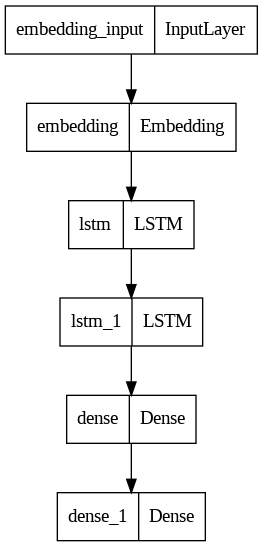

In [20]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False
)

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint=ModelCheckpoint('next_words.h5', monitor='loss', verbose=1, save_best_only=True)

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001))
model.fit(X, y, epochs=80, batch_size=64, callbacks=[checkpoint])

Epoch 1/80
463/463 [==============================] - ETA: 0s - loss: 6.6988
Epoch 1: loss improved from inf to 6.69879, saving model to next_words.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


463/463 [==============================] - 18s 25ms/step - loss: 6.6988
Epoch 2/80
463/463 [==============================] - ETA: 0s - loss: 6.2740
Epoch 2: loss improved from 6.69879 to 6.27397, saving model to next_words.h5
463/463 [==============================] - 8s 18ms/step - loss: 6.2740
Epoch 3/80
463/463 [==============================] - ETA: 0s - loss: 5.9393
Epoch 3: loss improved from 6.27397 to 5.93934, saving model to next_words.h5
463/463 [==============================] - 8s 17ms/step - loss: 5.9393
Epoch 4/80
463/463 [==============================] - ETA: 0s - loss: 5.6503
Epoch 4: loss improved from 5.93934 to 5.65026, saving model to next_words.h5
463/463 [==============================] - 8s 17ms/step - loss: 5.6503
Epoch 5/80
460/463 [============================>.] - ETA: 0s - loss: 5.3968
Epoch 5: loss improved from 5.65026 to 5.39694, saving model to next_words.h5
463/463 [==============================] - 8s 17ms/step - loss: 5.3969
Epoch 6/80
463/463 [====

In [22]:
#predict

from tensorflow.keras.models import load_model
model=load_model('next_words.h5')
tokenizer=pickle.load(open('token.pkl', 'rb'))
def predict_Next_Words(model, tokenizer, text):
  sequence=tokenizer.texts_to_sequences([text])
  preds=np.argmax(model.predict(sequence))
  predicted_word=""
  for key, value in tokenizer.word_index.items():
    if value==preds:
      predicted_word=key
      break
  print(predicted_word)
  return predicted_word


In [23]:
while(True):
  text=input("Enter your line: ")
  if text=="0":
    print("Execution Completed.....")
    break
  else:
    try:
      text=text.split()
      text=text[-3:]
      print(text)

      predict_Next_Words(model, tokenizer, text)
    except Exception as e:
      print("Error Occurred.", e)
      continue

Enter your line: Except as permitted
['Except', 'as', 'permitted']
1/1 [==============================] - 1s 911ms/step
under
Enter your line: 0
Execution Completed.....
